In [1]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
import nibabel as nib
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from scipy.spatial.distance import directed_hausdorff
from scipy import ndimage

In [2]:
data_dir = "/kaggle/input/resized-liver-tumor/resized_save"
volume_dir = os.path.join(data_dir, "vol")
seg_dir = os.path.join(data_dir, "seg")

data = []
for i in range(132):  # 0 to 131
    volume_path = os.path.join(volume_dir, f"volume-{i}.nii")
    seg_path = os.path.join(seg_dir, f"segmentation-{i}.nii")
    if os.path.exists(volume_path) and os.path.exists(seg_path):
        data.append({"volume": volume_path, "segmentation": seg_path})

df = pd.DataFrame(data)

In [3]:
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

In [4]:
tumor_data_dir =  "/kaggle/input/resized-liver-tumor/resized_save"
volumes = [f"{tumor_data_dir}/vol/volume-{i}.nii" for i in range(130)]
masks = [f"{tumor_data_dir}/seg/segmentation-{i}.nii" for i in range(130)]

tumor_df = pd.DataFrame({'volume': volumes, 'mask': masks})
tumor_train_df, tumor_test_val_df = train_test_split(tumor_df, test_size=0.3, random_state=42)
tumor_val_df, tumor_test_df = train_test_split(tumor_test_val_df, test_size=0.5, random_state=42)

In [5]:
def resize(vol, order):
    x = 128/vol.shape[0]
    y = 128/vol.shape[1]
    resize_factor = [x, y, 1]
    return ndimage.zoom(vol, resize_factor, order=order)

def one_hot_encode(mask, num_classes=3):
    # Assumes mask is in the shape (height, width, depth)
    # Use Python's built-in int type
    one_hot_mask = np.zeros((*mask.shape, num_classes), dtype=int)
    # For each class, zero out the channel that doesn't correspond to that class
    for i in range(num_classes):
        # this will make the mask as one hot encoded
        one_hot_mask[mask == i, i] = 1
    return one_hot_mask

In [6]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
import nibabel as nib
from scipy.ndimage import rotate
import random

class TumorDataset(Dataset):
    def __init__(self, dataframe: pd.DataFrame, patch_size=(128, 128, 64), augment=True):
        self.dataframe = dataframe
        self.patch_size = patch_size
        self.augment = augment

    def __len__(self):
        total_patches = 0
        for _, row in self.dataframe.iterrows():
            vol_file_path = row['volume']
            vol = nib.load(vol_file_path).get_fdata()
            num_patches = vol.shape[2] // self.patch_size[2]
            total_patches += num_patches
        return total_patches

    def augment_data(self, vol, mask):
        # Random flip
        if random.random() < 0.5:
            vol = np.flip(vol, axis=0).copy()
            mask = np.flip(mask, axis=0).copy()
        if random.random() < 0.5:
            vol = np.flip(vol, axis=1).copy()
            mask = np.flip(mask, axis=1).copy()

        # Random rotation
        if random.random() < 0.5:
            angle = random.uniform(-20, 20)
            vol = rotate(vol, angle, axes=(0, 1), reshape=False, order=1, mode='nearest')
            mask = rotate(mask, angle, axes=(0, 1), reshape=False, order=0, mode='nearest')

        # Random intensity shift for volume
        if random.random() < 0.5:
            shift = random.uniform(-0.1, 0.1)
            vol = vol + shift
            vol = np.clip(vol, -200, 250)

        return vol.copy(), mask.copy()  # Ensure contiguous arrays

    def __getitem__(self, index):
        vol_idx = 0
        patches_per_vol = []
        for _, row in self.dataframe.iterrows():
            vol_file_path = row['volume']
            vol = nib.load(vol_file_path).get_fdata()
            num_patches = vol.shape[2] // self.patch_size[2]
            patches_per_vol.append(num_patches)
            if index < sum(patches_per_vol):
                vol_file_path = row['volume']
                mask_file_path = row['mask']
                break
            vol_idx += 1

        vol = nib.load(vol_file_path).get_fdata()
        mask = nib.load(mask_file_path).get_fdata()
        vol = np.clip(vol, -200, 250)
        vol = resize(vol, order=3)
        mask = resize(mask, order=0)
        
        mask[mask == 1] = 0
        mask[mask == 2] = 1

        if self.augment:
            vol, mask = self.augment_data(vol, mask)

        vol_tensor = torch.tensor(vol, dtype=torch.float32).unsqueeze(0)
        mask_tensor = torch.tensor(mask, dtype=torch.float32).unsqueeze(0)
        
        patch_start = (index % patches_per_vol[vol_idx]) * self.patch_size[2]
        vol_patch = vol_tensor[:, :, :, patch_start:patch_start+self.patch_size[2]]
        mask_patch = mask_tensor[:, :, :, patch_start:patch_start+self.patch_size[2]]

        return vol_patch, mask_patch

def data_loader_tumor(data_df: pd.DataFrame, batch_size=1, augment=True):
    dataset = TumorDataset(data_df, augment=augment)
    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    return data_loader

In [7]:
train_loader = data_loader_tumor(tumor_train_df, batch_size=1)
val_loader = data_loader_tumor(tumor_val_df, batch_size=1)
test_loader = data_loader_tumor(tumor_test_df, batch_size = 1)

In [8]:
for i, (vol, mask) in enumerate(val_loader):
    if i != 0:
        break
    print(vol.shape,mask.shape)

torch.Size([1, 1, 128, 128, 64]) torch.Size([1, 1, 128, 128, 64])


In [9]:
for i, (vol, mask) in enumerate(val_loader):
    if i >= 2:
        break
    if len(np.unique(mask))==2:
        print(i)
        for j in range(20):
            if 1 in mask[0,0,:,:,j]:
#                 plt.figsize(10,10)
                plt.imshow(vol[0,0,:,:,j], cmap='bone')
                plt.contour(mask[0,0,:,:,j],colors='blue', linewidths=1)
                plt.show()
        break

1


In [10]:
import copy
import torch
import torch.nn as nn
import torch.nn.functional as F
import math


import torch
import torch.nn as nn

class ChannelAttention(nn.Module):
    def __init__(self, in_channels, reduction_ratio=16):
        super(ChannelAttention, self).__init__()
        # Define the number of channels for the mid layer
        mid_channel = in_channels // reduction_ratio
        
        self.avg_pool = nn.AdaptiveAvgPool3d(1)
        self.max_pool = nn.AdaptiveMaxPool3d(1)
        
        # Shared MLP
        self.shared_mlp = nn.Sequential(
            nn.Conv3d(in_channels, mid_channel, kernel_size=1, bias=False),
            nn.ReLU(inplace=True),
            nn.Conv3d(mid_channel, in_channels, kernel_size=1, bias=False)
        )
        
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_pooled = self.avg_pool(x)
        max_pooled = self.max_pool(x)
        
        avg_out = self.shared_mlp(avg_pooled)
        max_out = self.shared_mlp(max_pooled)
        
        # Sum of average and max outputs
        out = avg_out + max_out
        scale = self.sigmoid(out)  # Activation
        return x * scale




class SingleDeconv3DBlock(nn.Module):
    def __init__(self, in_planes, out_planes):
        super().__init__()
        self.block = nn.ConvTranspose3d(in_planes, out_planes, kernel_size=2, stride=2, padding=0, output_padding=0)

    def forward(self, x):
        return self.block(x)


class SingleConv3DBlock(nn.Module):
    def __init__(self, in_planes, out_planes, kernel_size):
        super().__init__()
        self.block = nn.Conv3d(in_planes, out_planes, kernel_size=kernel_size, stride=1,
                               padding=((kernel_size - 1) // 2))

    def forward(self, x):
        return self.block(x)


class Conv3DBlock(nn.Module):
    def __init__(self, in_planes, out_planes, kernel_size=3):
        super().__init__()
        self.block = nn.Sequential(
            SingleConv3DBlock(in_planes, out_planes, kernel_size),
            nn.BatchNorm3d(out_planes),
            nn.ReLU(True)
        )

    def forward(self, x):
        return self.block(x)


class Deconv3DBlock(nn.Module):
    def __init__(self, in_planes, out_planes, kernel_size=3):
        super().__init__()
        self.block = nn.Sequential(
            SingleDeconv3DBlock(in_planes, out_planes),
            SingleConv3DBlock(out_planes, out_planes, kernel_size),
            nn.BatchNorm3d(out_planes),
            nn.ReLU(True)
        )

    def forward(self, x):
        return self.block(x)


class SelfAttention(nn.Module):
    def __init__(self, num_heads, embed_dim, dropout):
        super().__init__()
        self.num_attention_heads = num_heads
        self.attention_head_size = int(embed_dim / num_heads)
        self.all_head_size = self.num_attention_heads * self.attention_head_size

        self.query = nn.Linear(embed_dim, self.all_head_size)
        self.key = nn.Linear(embed_dim, self.all_head_size)
        self.value = nn.Linear(embed_dim, self.all_head_size)

        self.out = nn.Linear(embed_dim, embed_dim)
        self.attn_dropout = nn.Dropout(dropout)
        self.proj_dropout = nn.Dropout(dropout)

        self.softmax = nn.Softmax(dim=-1)

        self.vis = False

    def transpose_for_scores(self, x):
        new_x_shape = x.size()[:-1] + (self.num_attention_heads, self.attention_head_size)
        x = x.view(*new_x_shape)
        return x.permute(0, 2, 1, 3)

    def forward(self, hidden_states):
        mixed_query_layer = self.query(hidden_states)
        mixed_key_layer = self.key(hidden_states)
        mixed_value_layer = self.value(hidden_states)

        query_layer = self.transpose_for_scores(mixed_query_layer)
        key_layer = self.transpose_for_scores(mixed_key_layer)
        value_layer = self.transpose_for_scores(mixed_value_layer)

        attention_scores = torch.matmul(query_layer, key_layer.transpose(-1, -2))
        attention_scores = attention_scores / math.sqrt(self.attention_head_size)
        attention_probs = self.softmax(attention_scores)
        weights = attention_probs if self.vis else None
        attention_probs = self.attn_dropout(attention_probs)

        context_layer = torch.matmul(attention_probs, value_layer)
        context_layer = context_layer.permute(0, 2, 1, 3).contiguous()
        new_context_layer_shape = context_layer.size()[:-2] + (self.all_head_size,)
        context_layer = context_layer.view(*new_context_layer_shape)
        attention_output = self.out(context_layer)
        attention_output = self.proj_dropout(attention_output)
        
        # Return a tensor for weights even if self.vis is False
        return attention_output, attention_probs if self.vis else attention_output.new_zeros(attention_output.size(0), self.num_attention_heads, attention_output.size(1), attention_output.size(1))


class Mlp(nn.Module):
    def __init__(self, in_features, act_layer=nn.GELU, drop=0.):
        super().__init__()
        self.fc1 = nn.Linear(in_features, in_features)
        self.act = act_layer()
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        x = self.fc1()
        x = self.act(x)
        x = self.drop(x)
        return x


class PositionwiseFeedForward(nn.Module):
    def __init__(self, d_model=786, d_ff=2048, dropout=0.1):
        super().__init__()
        # Torch linears have a `b` by default.
        self.w_1 = nn.Linear(d_model, d_ff)
        self.w_2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        return self.w_2(self.dropout(F.relu(self.w_1(x))))


class Embeddings(nn.Module):
    def __init__(self, input_dim, embed_dim, cube_size, patch_size, dropout):
        super().__init__()
        self.n_patches = int((cube_size[0] * cube_size[1] * cube_size[2]) / (patch_size * patch_size * patch_size))
        self.patch_size = patch_size
        self.embed_dim = embed_dim
        self.patch_embeddings = nn.Conv3d(in_channels=input_dim, out_channels=embed_dim,
                                          kernel_size=patch_size, stride=patch_size)
        self.position_embeddings = nn.Parameter(torch.zeros(1, self.n_patches, embed_dim))
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.patch_embeddings(x)
        x = x.flatten(2)
        x = x.transpose(-1, -2)
        embeddings = x + self.position_embeddings
        embeddings = self.dropout(embeddings)
        return embeddings


class TransformerBlock(nn.Module):
    def __init__(self, embed_dim, num_heads, dropout, cube_size, patch_size):
        super().__init__()
        self.attention_norm = nn.LayerNorm(embed_dim, eps=1e-6)
        self.mlp_norm = nn.LayerNorm(embed_dim, eps=1e-6)
        self.mlp_dim = int((cube_size[0] * cube_size[1] * cube_size[2]) / (patch_size * patch_size * patch_size))
        self.mlp = PositionwiseFeedForward(embed_dim, 2048)
        self.attn = SelfAttention(num_heads, embed_dim, dropout)

    def forward(self, x):
        h = x
        x = self.attention_norm(x)
        x, weights = self.attn(x)
        x = x + h
        h = x

        x = self.mlp_norm(x)
        x = self.mlp(x)

        x = x + h
        return x, weights


class Transformer(nn.Module):
    def __init__(self, input_dim, embed_dim, cube_size, patch_size, num_heads, num_layers, dropout, extract_layers):
        super().__init__()
        self.embeddings = Embeddings(input_dim, embed_dim, cube_size, patch_size, dropout)
        self.layer = nn.ModuleList()
        self.encoder_norm = nn.LayerNorm(embed_dim, eps=1e-6)
        self.extract_layers = extract_layers
        for _ in range(num_layers):
            layer = TransformerBlock(embed_dim, num_heads, dropout, cube_size, patch_size)
            self.layer.append(copy.deepcopy(layer))

    def forward(self, x):
        extract_layers = []
        hidden_states = self.embeddings(x)

        for depth, layer_block in enumerate(self.layer):
            hidden_states, _ = layer_block(hidden_states)
            if depth + 1 in self.extract_layers:
                extract_layers.append(hidden_states)

        return extract_layers


class UNETR_ATT(nn.Module):
    def __init__(self, img_shape=(128, 128, 128), input_dim=4, output_dim=3, embed_dim=768, patch_size=16, num_heads=12, dropout=0.1):
        super().__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.embed_dim = embed_dim
        self.img_shape = img_shape
        self.patch_size = patch_size
        self.num_heads = num_heads
        self.dropout = dropout
        self.num_layers = 12
        self.ext_layers = [3, 6, 9, 12]

        self.patch_dim = [int(x / patch_size) for x in img_shape]

        # Transformer Encoder
        self.transformer = \
            Transformer(
                input_dim,
                embed_dim,
                img_shape,
                patch_size,
                num_heads,
                self.num_layers,
                dropout,
                self.ext_layers
            )

        # Channel Attention for each depth
        self.channel_attention_z12 = ChannelAttention(embed_dim)
        self.channel_attention_z9 = ChannelAttention(embed_dim)
        self.channel_attention_z6 = ChannelAttention(embed_dim)
        self.channel_attention_z3 = ChannelAttention(embed_dim)

        # U-Net Decoder
        self.decoder0 = \
            nn.Sequential(
                Conv3DBlock(input_dim, 32, 3),
                Conv3DBlock(32, 64, 3)
            )

        self.decoder3 = \
            nn.Sequential(
                Deconv3DBlock(embed_dim, 512),
                Deconv3DBlock(512, 256),
                Deconv3DBlock(256, 128)
            )

        self.decoder6 = \
            nn.Sequential(
                Deconv3DBlock(embed_dim, 512),
                Deconv3DBlock(512, 256),
            )

        self.decoder9 = \
            Deconv3DBlock(embed_dim, 512)

        self.decoder12_upsampler = \
            SingleDeconv3DBlock(embed_dim, 512)

        self.decoder9_upsampler = \
            nn.Sequential(
                Conv3DBlock(1024, 512),
                Conv3DBlock(512, 512),
                Conv3DBlock(512, 512),
                SingleDeconv3DBlock(512, 256)
            )

        self.decoder6_upsampler = \
            nn.Sequential(
                Conv3DBlock(512, 256),
                Conv3DBlock(256, 256),
                SingleDeconv3DBlock(256, 128)
            )

        self.decoder3_upsampler = \
            nn.Sequential(
                Conv3DBlock(256, 128),
                Conv3DBlock(128, 128),
                SingleDeconv3DBlock(128, 64)
            )

        self.decoder0_header = \
            nn.Sequential(
                Conv3DBlock(128, 64),
                Conv3DBlock(64, 64),
                SingleConv3DBlock(64, output_dim, 1)
            )

    def forward(self, x):
        z = self.transformer(x)
        z0, z3, z6, z9, z12 = x, *z
        
        z3 = z3.transpose(-1, -2).view(-1, self.embed_dim, *self.patch_dim)
        z6 = z6.transpose(-1, -2).view(-1, self.embed_dim, *self.patch_dim)
        z9 = z9.transpose(-1, -2).view(-1, self.embed_dim, *self.patch_dim)
        z12 = z12.transpose(-1, -2).view(-1, self.embed_dim, *self.patch_dim)

        z12 = self.channel_attention_z12(z12)
        z12 = self.decoder12_upsampler(z12)

        z9 = self.channel_attention_z9(z9)
        z9 = self.decoder9(z9)
        z9 = self.decoder9_upsampler(torch.cat([z9, z12], dim=1))

        z6 = self.channel_attention_z6(z6)
        z6 = self.decoder6(z6)
        z6 = self.decoder6_upsampler(torch.cat([z6, z9], dim=1))

        z3 = self.channel_attention_z3(z3)
        z3 = self.decoder3(z3)
        z3 = self.decoder3_upsampler(torch.cat([z3, z6], dim=1))

        z0 = self.decoder0(z0)
        output = self.decoder0_header(torch.cat([z0, z3], dim=1))
        return output


In [11]:
import torch
import os
torch.cuda.empty_cache()
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")
    print(f"CUDA memory allocated: {torch.cuda.memory_allocated(0) / 1e9:.2f} GB")
    print(f"CUDA memory cached: {torch.cuda.memory_reserved(0) / 1e9:.2f} GB")

# Set environment variable for CUDA error reporting
os.environ['CUDA_LAUNCH_BLOCKING'] = '0'

CUDA available: True
CUDA device: Tesla P100-PCIE-16GB
CUDA memory allocated: 0.00 GB
CUDA memory cached: 0.00 GB


In [12]:
def evaluate(model, dataloader, dice_metric, asd_metric):
    model.eval()
    dice_metric.reset()
    asd_metric.reset()
    device = torch.device("cuda")
    with torch.no_grad():
        for volume, segmentation in dataloader:
            volume, segmentation = volume.to(device), segmentation.to(device)
            
            # Ensure correct dimensions
            if volume.dim() == 3:
                volume = volume.unsqueeze(0).unsqueeze(0)
            elif volume.dim() == 4:
                volume = volume.unsqueeze(0)
            
            if segmentation.dim() == 3:
                segmentation = segmentation.unsqueeze(0).unsqueeze(0)
            elif segmentation.dim() == 4:
                segmentation = segmentation.unsqueeze(0)
            
            output = model(volume)
            output = AsDiscrete(threshold=0.5)(output)
            
            dice_metric(y_pred=output, y=segmentation)
            asd_metric(y_pred=output, y=segmentation)
    
    dice = dice_metric.aggregate().item()
    asd = asd_metric.aggregate().item()
    return dice, asd

In [13]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score
import pandas as pd
import tqdm

def dice_score(y_true, y_pred, smooth=1e-6):
    y_true_f = y_true.view(-1)
    y_pred_f = y_pred.view(-1)
    intersection = torch.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (torch.sum(y_true_f) + torch.sum(y_pred_f) + smooth)

def iou_score(y_true, y_pred, smooth=1e-6):
    y_true_f = y_true.view(-1)
    y_pred_f = y_pred.view(-1)
    intersection = torch.sum(y_true_f * y_pred_f)
    union = torch.sum(y_true_f) + torch.sum(y_pred_f) - intersection
    return (intersection + smooth) / (union + smooth)

def weighted_dice_loss(y_true, y_pred, weight_factor=0.5):
    y_pred = torch.sigmoid(y_pred)
    y_true_f = y_true.view(-1)
    y_pred_f = y_pred.view(-1)
    weights = y_true_f * weight_factor + 1.0
    intersection = torch.sum(weights * y_true_f * y_pred_f)
    total = torch.sum(weights * y_true_f) + torch.sum(weights * y_pred_f)
    dice = (2. * intersection + 1e-6) / (total + 1e-6)
    return 1 - dice

def focal_binary_cross_entropy(y_true, y_pred, gamma=2.0, alpha=0.25):
    y_pred = torch.sigmoid(y_pred)
    bce_loss = F.binary_cross_entropy(y_pred, y_true, reduction='none')
    pt = torch.where(y_true == 1, y_pred, 1 - y_pred)
    focal_loss = alpha * (1 - pt) ** gamma * bce_loss
    return torch.mean(focal_loss)

def calculate_metrics(y_true, y_pred):
    y_true = y_true.cpu().numpy().flatten()
    y_pred = y_pred.cpu().numpy().flatten()
    return {
        'precision': precision_score(y_true, y_pred, zero_division=0),
        'recall': recall_score(y_true, y_pred, zero_division=0),
        'f1': f1_score(y_true, y_pred, zero_division=0),
    }

def weighted_dice_loss(inputs, targets, smooth=1e-6, weight_factor=0.5):
    # Sigmoid activation to convert logits to probabilities
    inputs = torch.sigmoid(inputs)

    # Flatten the tensors
    inputs = inputs.view(-1)
    targets = targets.view(-1)

    # Compute weights: More weight on the positive class (tumor) regions
    weights = targets * weight_factor + 1.0

    # Compute weighted intersection and union
    intersection = torch.sum(weights * inputs * targets)
    total = torch.sum(weights * inputs) + torch.sum(weights * targets)

    # Compute weighted Dice coefficient
    dice = (2. * intersection + smooth) / (total + smooth)

    # Return weighted Dice loss
    return 1 - dice

In [14]:
def train(model, train_loader, val_loader, num_epochs, learning_rate, device):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    criterion = weighted_dice_loss
    
    best_val_dice = 0.0
    history = {
        'train_loss': [], 'val_loss': [],
        'train_dice': [], 'val_dice': [],
        'train_iou': [], 'val_iou': [],
        'train_precision': [], 'val_precision': [],
        'train_recall': [], 'val_recall': [],
        'train_f1': [], 'val_f1': []
    }
    
    for epoch in tqdm.tqdm(range(num_epochs)):
        model.train()
        train_losses = []
        train_metrics = {
            'dice': [], 'iou': [], 'precision': [], 'recall': [], 'f1': []
        }
        
        for vol, mask in train_loader:
            vol, mask = vol.to(device), mask.to(device)
            
            optimizer.zero_grad()
            output = model(vol)
            loss = weighted_dice_loss(output, mask)
            loss.backward()
            optimizer.step()
            
            train_losses.append(loss.item())
            
            # Calculate metrics
            output_binary = (torch.sigmoid(output) > 0.5).float()
            train_metrics['dice'].append(dice_score(mask, output_binary).item())
            train_metrics['iou'].append(iou_score(mask, output_binary).item())
            batch_metrics = calculate_metrics(mask, output_binary)
            train_metrics['precision'].append(batch_metrics['precision'])
            train_metrics['recall'].append(batch_metrics['recall'])
            train_metrics['f1'].append(batch_metrics['f1'])
        
        # Evaluate on validation set
        val_loss, val_metrics = evaluate(model, val_loader, device, criterion)
        
        # Update history
        history['train_loss'].append(np.mean(train_losses))
        history['val_loss'].append(val_loss)
        for metric in ['dice', 'iou', 'precision', 'recall', 'f1']:
            history[f'train_{metric}'].append(np.mean(train_metrics[metric]))
            history[f'val_{metric}'].append(val_metrics[metric])
        
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {history['train_loss'][-1]:.4f}, "
              f"Val Loss: {history['val_loss'][-1]:.4f}, "
              f"Val Dice: {history['val_dice'][-1]:.4f}, Val IoU: {history['val_iou'][-1]:.4f}")
        
        if history['val_dice'][-1] > best_val_dice:
            best_val_dice = history['val_dice'][-1]
            torch.save(model.state_dict(), "best_model.pth")
    
    # Save history to CSV
    pd.DataFrame(history).to_csv('training_history.csv', index=False)
    
    # Plot and save graphs
    plot_metrics(history)
    
    return pd.read_csv('training_history.csv')

def evaluate(model, dataloader, device, criterion):
    model.eval()
    val_losses = []
    val_metrics = {
        'dice': [], 'iou': [], 'precision': [], 'recall': [], 'f1': []
    }
    
    with torch.no_grad():
        for vol, mask in dataloader:
            vol, mask = vol.to(device), mask.to(device)
            output = model(vol)
            loss = criterion(output, mask)
            val_losses.append(loss.item())
            
            output_binary = (torch.sigmoid(output) > 0.5).float()
            val_metrics['dice'].append(dice_score(mask, output_binary).item())
            val_metrics['iou'].append(iou_score(mask, output_binary).item())
            batch_metrics = calculate_metrics(mask, output_binary)
            val_metrics['precision'].append(batch_metrics['precision'])
            val_metrics['recall'].append(batch_metrics['recall'])
            val_metrics['f1'].append(batch_metrics['f1'])
    
    return np.mean(val_losses), {k: np.mean(v) for k, v in val_metrics.items()}

def plot_metrics(history):
    metrics = ['loss', 'dice', 'iou', 'precision', 'recall', 'f1']
    fig, axes = plt.subplots(2, 3, figsize=(20, 12))
    fig.suptitle('Training Metrics')
    
    for i, metric in enumerate(metrics):
        ax = axes[i // 3, i % 3]
        ax.plot(history[f'train_{metric}'], label=f'Train {metric.capitalize()}')
        ax.plot(history[f'val_{metric}'], label=f'Val {metric.capitalize()}')
        ax.set_title(f'{metric.capitalize()} over epochs')
        ax.set_xlabel('Epoch')
        ax.set_ylabel(metric.capitalize())
        ax.legend()
    
    plt.tight_layout()
    plt.savefig('training_metrics.png')
    plt.close()

# Training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNETR_ATT(img_shape=(128, 128, 64), input_dim=1, output_dim=1)  # Assuming binary segmentation
model_path = "/kaggle/input/best-model-transformer/best_model.pth"
if os.path.exists(model_path):
    model.load_state_dict(torch.load(model_path))
    print("Model loaded from disk")
train(model, train_loader, val_loader, num_epochs=25, learning_rate=1e-4, device=device)

Model loaded from disk


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch 1/25, Train Loss: 0.9502, Val Loss: 0.9491, Val Dice: 0.0519, Val IoU: 0.0307


  8%|▊         | 2/25 [40:39<7:40:46, 1202.03s/it]

Epoch 2/25, Train Loss: 0.9271, Val Loss: 0.9569, Val Dice: 0.0367, Val IoU: 0.0210
Epoch 3/25, Train Loss: 0.9175, Val Loss: 0.9358, Val Dice: 0.0645, Val IoU: 0.0406


 16%|█▌        | 4/25 [1:18:02<6:41:53, 1148.25s/it]

Epoch 4/25, Train Loss: 0.9141, Val Loss: 0.9322, Val Dice: 0.0634, Val IoU: 0.0385
Epoch 5/25, Train Loss: 0.9048, Val Loss: 0.9205, Val Dice: 0.0926, Val IoU: 0.0584


 20%|██        | 5/25 [1:36:39<6:19:00, 1137.05s/it]

Epoch 6/25, Train Loss: 0.8961, Val Loss: 0.8999, Val Dice: 0.1051, Val IoU: 0.0660


 24%|██▍       | 6/25 [1:55:14<5:57:40, 1129.51s/it]

Epoch 7/25, Train Loss: 0.8941, Val Loss: 0.8994, Val Dice: 0.1128, Val IoU: 0.0743


 28%|██▊       | 7/25 [2:14:02<5:38:41, 1128.95s/it]

Epoch 8/25, Train Loss: 0.8869, Val Loss: 0.8920, Val Dice: 0.1211, Val IoU: 0.0781


 32%|███▏      | 8/25 [2:32:39<5:18:45, 1125.01s/it]

Epoch 9/25, Train Loss: 0.8788, Val Loss: 0.8834, Val Dice: 0.1291, Val IoU: 0.0850


 40%|████      | 10/25 [3:09:58<4:40:39, 1122.66s/it]

Epoch 10/25, Train Loss: 0.8729, Val Loss: 0.8787, Val Dice: 0.1251, Val IoU: 0.0811
Epoch 11/25, Train Loss: 0.8661, Val Loss: 0.8877, Val Dice: 0.1317, Val IoU: 0.0871


 48%|████▊     | 12/25 [3:47:09<4:02:28, 1119.12s/it]

Epoch 12/25, Train Loss: 0.8625, Val Loss: 0.9123, Val Dice: 0.0828, Val IoU: 0.0498


 52%|█████▏    | 13/25 [4:05:44<3:43:35, 1117.95s/it]

Epoch 13/25, Train Loss: 0.8564, Val Loss: 0.8794, Val Dice: 0.1273, Val IoU: 0.0851
Epoch 14/25, Train Loss: 0.8526, Val Loss: 0.8548, Val Dice: 0.1500, Val IoU: 0.1018


 60%|██████    | 15/25 [4:43:10<3:06:46, 1120.67s/it]

Epoch 15/25, Train Loss: 0.8449, Val Loss: 0.8519, Val Dice: 0.1455, Val IoU: 0.1004
Epoch 16/25, Train Loss: 0.8423, Val Loss: 0.8477, Val Dice: 0.1513, Val IoU: 0.1024


 68%|██████▊   | 17/25 [5:20:34<2:29:26, 1120.76s/it]

Epoch 17/25, Train Loss: 0.8299, Val Loss: 0.8560, Val Dice: 0.1410, Val IoU: 0.0924
Epoch 18/25, Train Loss: 0.8233, Val Loss: 0.8357, Val Dice: 0.1564, Val IoU: 0.1057


 72%|███████▏  | 18/25 [5:39:14<2:10:44, 1120.59s/it]

Epoch 19/25, Train Loss: 0.8209, Val Loss: 0.8181, Val Dice: 0.2095, Val IoU: 0.1526


 80%|████████  | 20/25 [6:16:22<1:33:04, 1116.95s/it]

Epoch 20/25, Train Loss: 0.8135, Val Loss: 0.8274, Val Dice: 0.1653, Val IoU: 0.1163


 84%|████████▍ | 21/25 [6:35:00<1:14:29, 1117.33s/it]

Epoch 21/25, Train Loss: 0.8084, Val Loss: 0.8466, Val Dice: 0.1520, Val IoU: 0.1011


 88%|████████▊ | 22/25 [6:53:28<55:43, 1114.57s/it]  

Epoch 22/25, Train Loss: 0.8040, Val Loss: 0.8357, Val Dice: 0.1558, Val IoU: 0.1067


 92%|█████████▏| 23/25 [7:11:52<37:02, 1111.38s/it]

Epoch 23/25, Train Loss: 0.7958, Val Loss: 0.8536, Val Dice: 0.1914, Val IoU: 0.1478


 96%|█████████▌| 24/25 [7:30:15<18:28, 1108.99s/it]

Epoch 24/25, Train Loss: 0.8038, Val Loss: 0.8356, Val Dice: 0.1515, Val IoU: 0.1009


100%|██████████| 25/25 [7:48:50<00:00, 1125.23s/it]

Epoch 25/25, Train Loss: 0.7926, Val Loss: 0.8253, Val Dice: 0.1647, Val IoU: 0.1133


,train_loss,val_loss,train_dice,val_dice,train_iou,val_iou,train_precision,val_precision,train_recall,val_recall,train_f1,val_f1
0,0.950188,0.949115,0.076227,0.051910,0.057906,0.030665,0.035739,0.035554,0.287314,0.368810,0.044977,0.051910
1,0.927103,0.956937,0.072200,0.036736,0.045730,0.021034,0.051368,0.021264,0.383811,0.607470,0.072200,0.036736
2,0.917489,0.935844,0.080747,0.064538,0.052529,0.040617,0.058075,0.046842,0.443921,0.579061,0.080747,0.064538
3,0.914115,0.932203,0.085218,0.063384,0.056554,0.038530,0.065358,0.046729,0.402235,0.569978,0.085218,0.063384
4,0.904812,0.920464,0.096363,0.092554,0.064435,0.058438,0.074870,0.078972,0.407425,0.366768,0.096363,0.092554
5,0.896102,0.899889,0.110479,0.105113,0.074347,0.066038,0.090938,0.088553,0.385050,0.366030,0.110479,0.105113
6,0.894069,0.899430,0.106247,0.112848,0.071538,0.074282,0.087125,0.092689,0.376296,0.524292,0.106247,0.112848
7,0.886908,0.891971,0.114731,0.121064,0.077227,0.078069,0.095938,0.092152,0.365187,0.402084,0.114731,0.121064
8,0.878798,0.883446,0.123987,0.129141,0.084181,0.085010,0.109319,0.098091,0.341745,0.467434,0.123987,0.129141
9,0.872860,0.878700,0.129713,0.125075,0.087557,0.081106,0.117105,0.098998,0.345425,0.473791,0.129713,0.125075


In [15]:
model.load_state_dict(torch.load("best_model.pth"))
model.eval()

UNETR(
  (transformer): Transformer(
    (embeddings): Embeddings(
      (patch_embeddings): Conv3d(1, 768, kernel_size=(16, 16, 16), stride=(16, 16, 16))
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (layer): ModuleList(
      (0-11): 12 x TransformerBlock(
        (attention_norm): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp_norm): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): PositionwiseFeedForward(
          (w_1): Linear(in_features=768, out_features=2048, bias=True)
          (w_2): Linear(in_features=2048, out_features=768, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (attn): SelfAttention(
          (query): Linear(in_features=768, out_features=768, bias=True)
          (key): Linear(in_features=768, out_features=768, bias=True)
          (value): Linear(in_features=768, out_features=768, bias=True)
          (out): Linear(in_features=768, out_features=768, bias=True)
          (attn_dr

In [16]:
def run_test(model, test_loader, device):
    model.eval()
    test_metrics = {
        'dice': [], 'iou': [], 'precision': [], 'recall': [], 'f1': [], 'hausdorff': []
    }
    
    with torch.no_grad():
        for vol, mask in tqdm.tqdm(test_loader, desc="Testing"):
            vol, mask = vol.to(device), mask.to(device)
            output = model(vol)
            
            output_binary = (torch.sigmoid(output) > 0.5).float()
            
            test_metrics['dice'].append(dice_score(mask, output_binary).item())
            test_metrics['iou'].append(iou_score(mask, output_binary).item())
            
            batch_metrics = calculate_metrics(mask, output_binary)
            test_metrics['precision'].append(batch_metrics['precision'])
            test_metrics['recall'].append(batch_metrics['recall'])
            test_metrics['f1'].append(batch_metrics['f1'])
            
            # Calculate Hausdorff distance
#             for i in range(output.shape[0]):  # Loop through batch
#                 hd = compute_hausdorff_distance(mask[i, 0].cpu().numpy(), output_binary[i, 0].cpu().numpy())
#                 test_metrics['hausdorff'].append(hd)

    # Calculate average metrics
    avg_metrics = {k: np.mean(v) for k, v in test_metrics.items()}
    
    print("Test Results:")
    for metric, value in avg_metrics.items():
        print(f"{metric.capitalize()}: {value:.4f}")
    
    return avg_metrics

def compute_hausdorff_distance(true_mask, pred_mask):
    from scipy.spatial.distance import directed_hausdorff
    return max(directed_hausdorff(true_mask, pred_mask)[0],
               directed_hausdorff(pred_mask, true_mask)[0])

In [17]:


# Run test
test_metrics = run_test(model, test_loader, device)

# Save test metrics
pd.DataFrame([test_metrics]).to_csv('test_metrics.csv', index=False)

Testing: 100%|██████████| 41/41 [03:12<00:00,  4.70s/it]

Test Results:
Dice: 0.1366
Iou: 0.0959
Precision: 0.2180
Recall: 0.1901
F1: 0.1366
Hausdorff: nan



/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


skipping
skipping
skipping
skipping
skipping
skipping
skipping
skipping


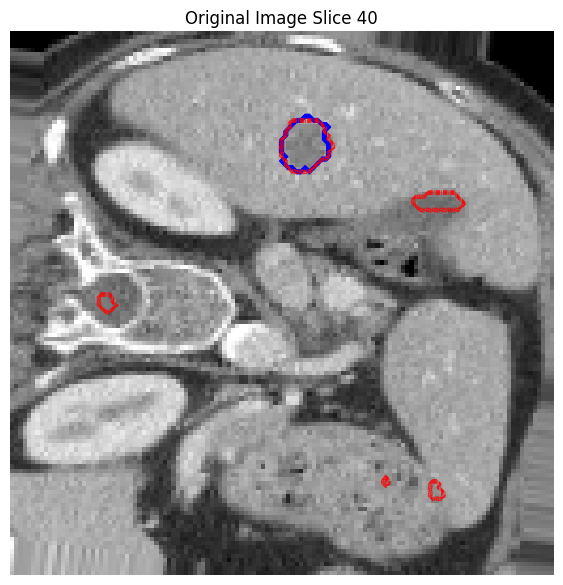

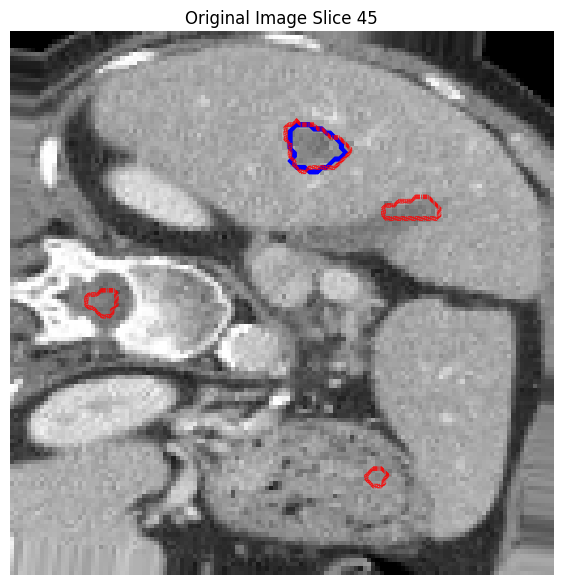

skipping
skipping
skipping
skipping


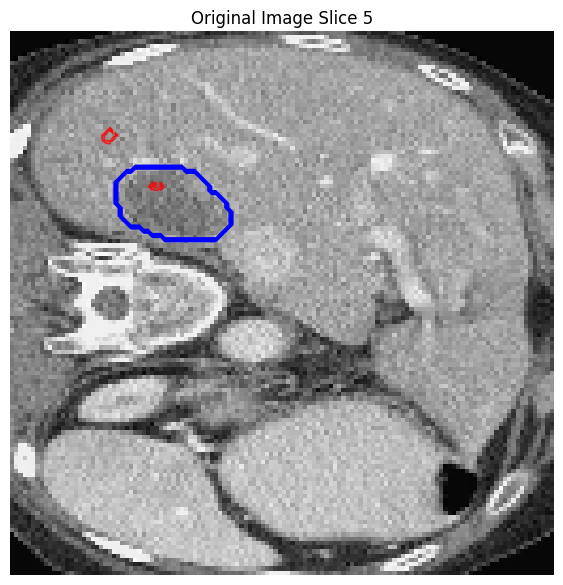

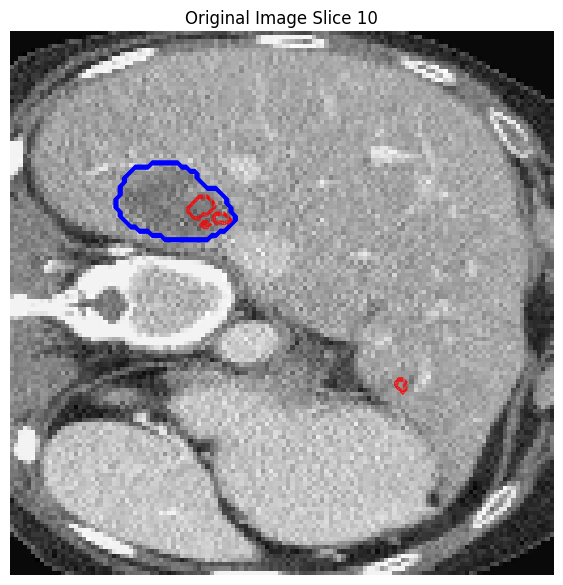

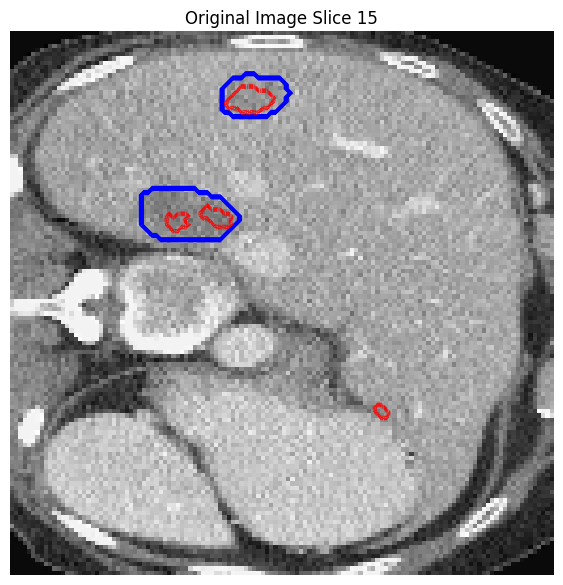

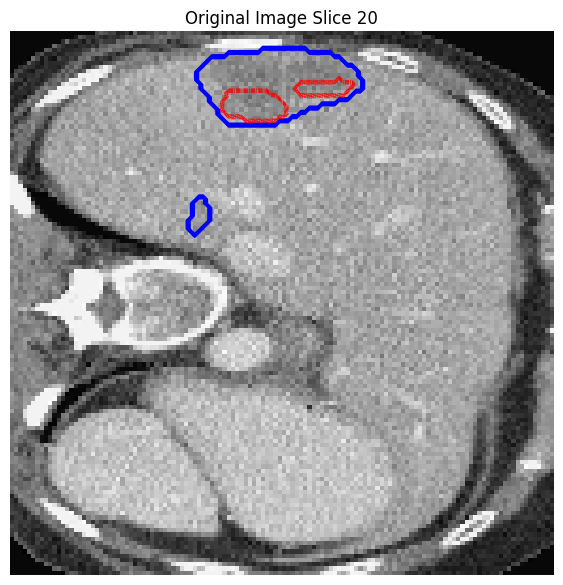

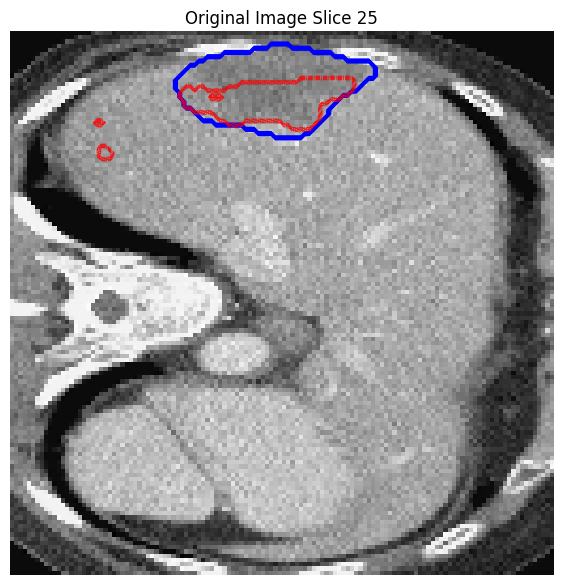

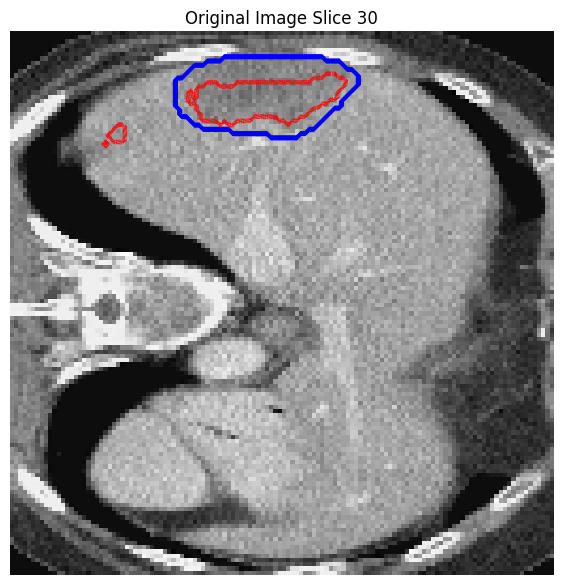

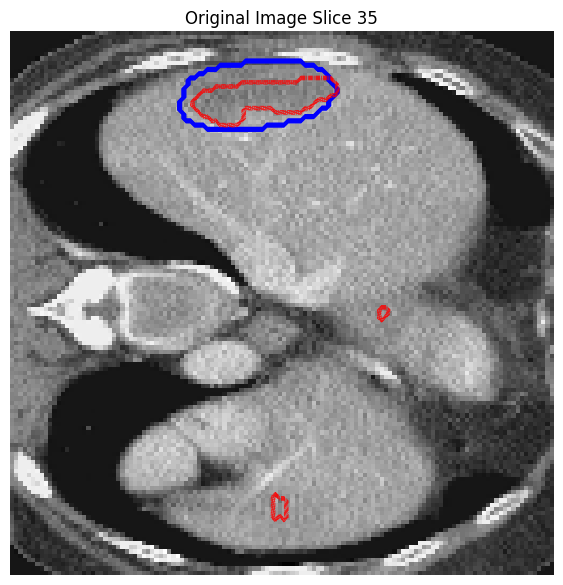

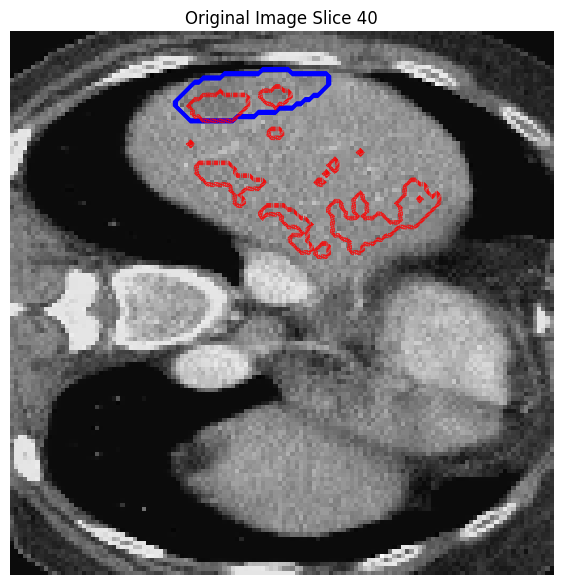

skipping
skipping
skipping
skipping
skipping


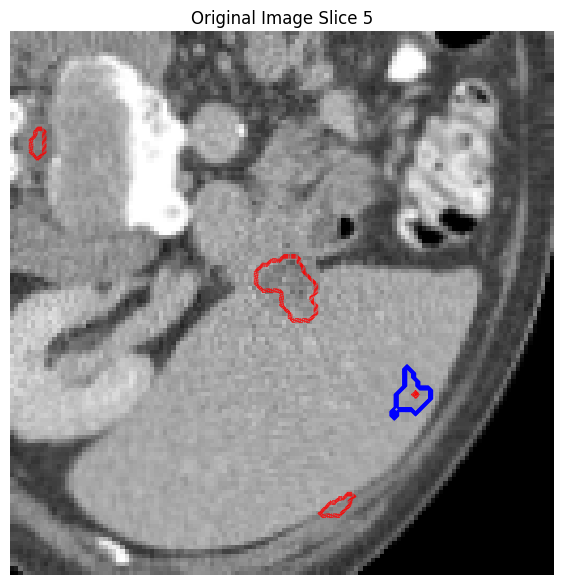

skipping
skipping
skipping
skipping
skipping
skipping
skipping
skipping
skipping
skipping
skipping
skipping
skipping
skipping
skipping
skipping
skipping


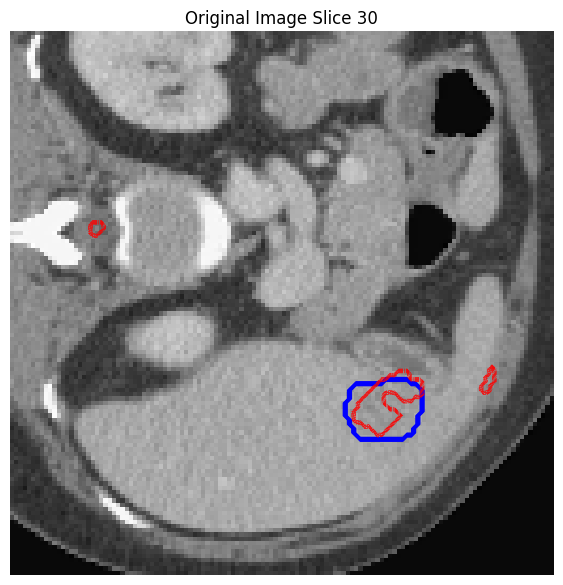

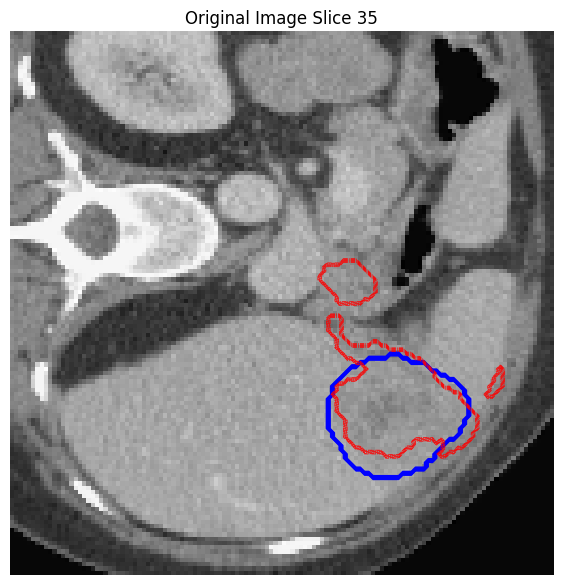

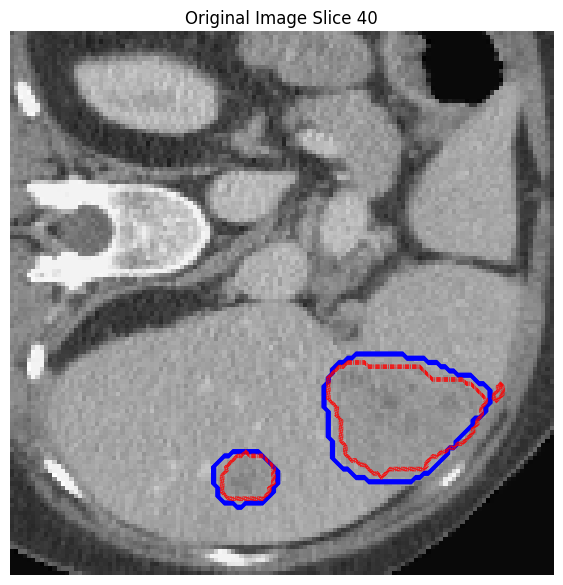

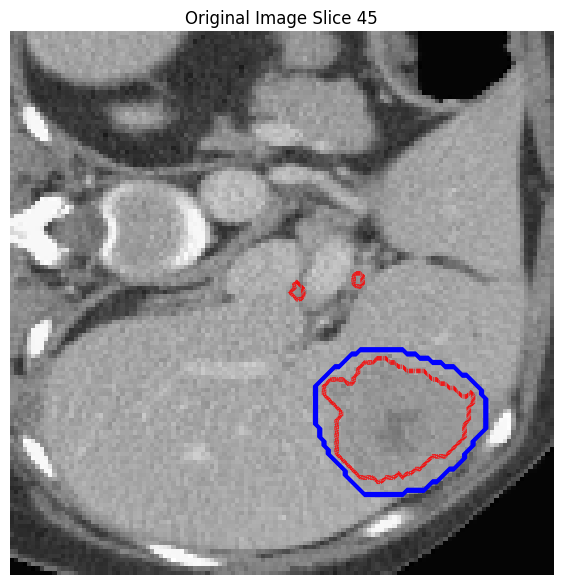

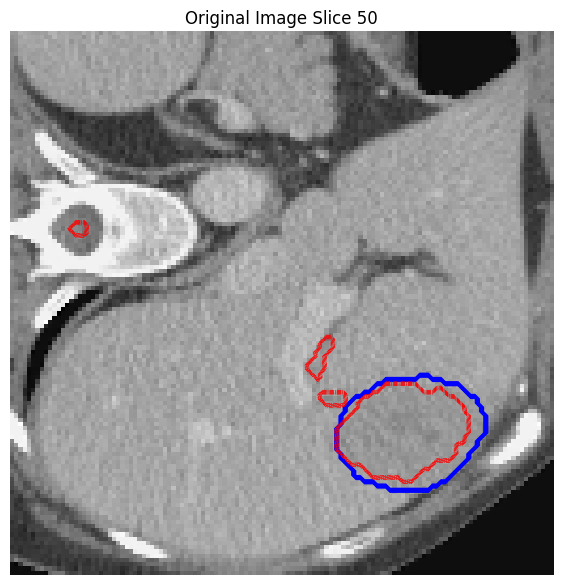

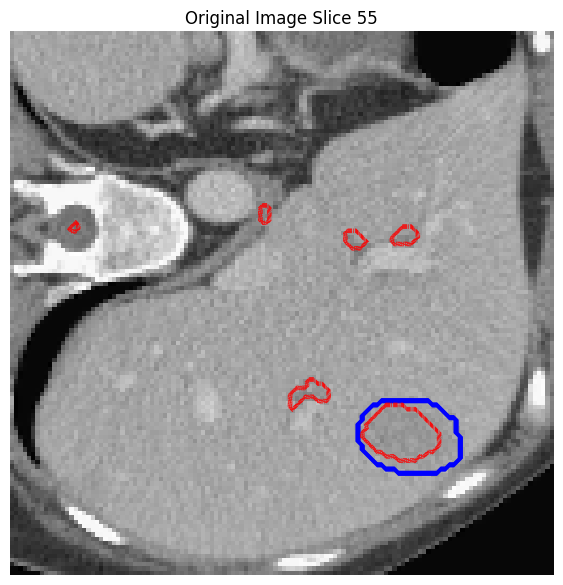

skipping
skipping
skipping
skipping
skipping


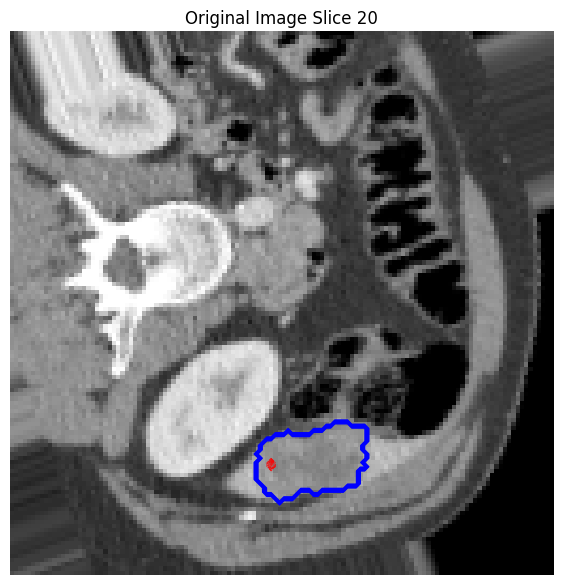

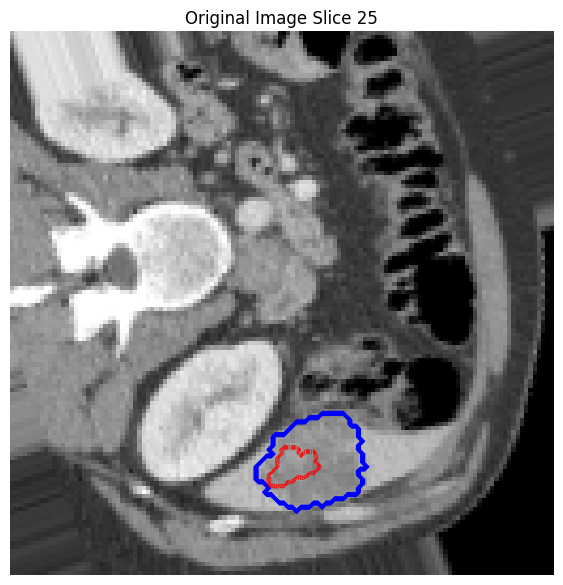

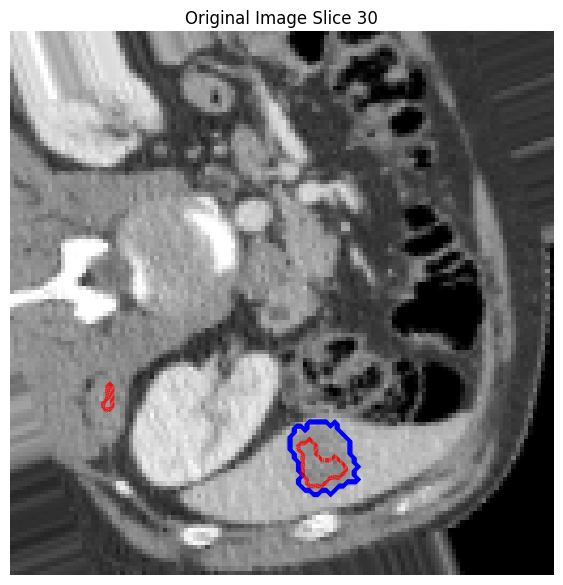

skipping
skipping
skipping


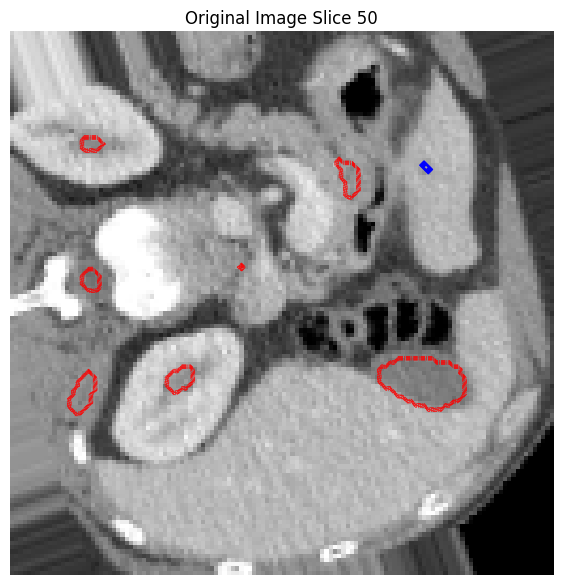

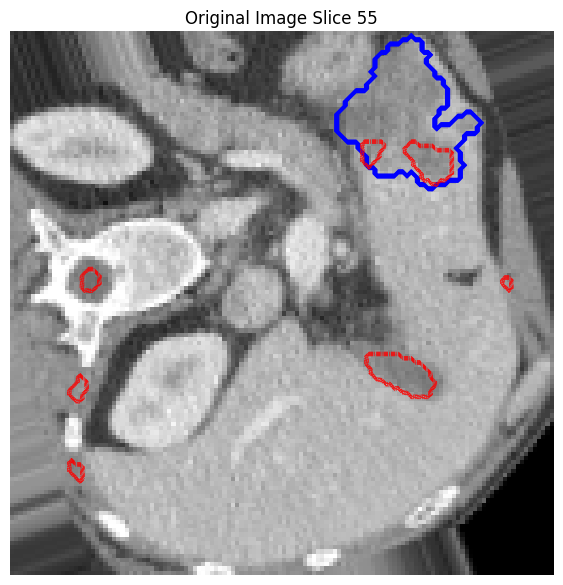

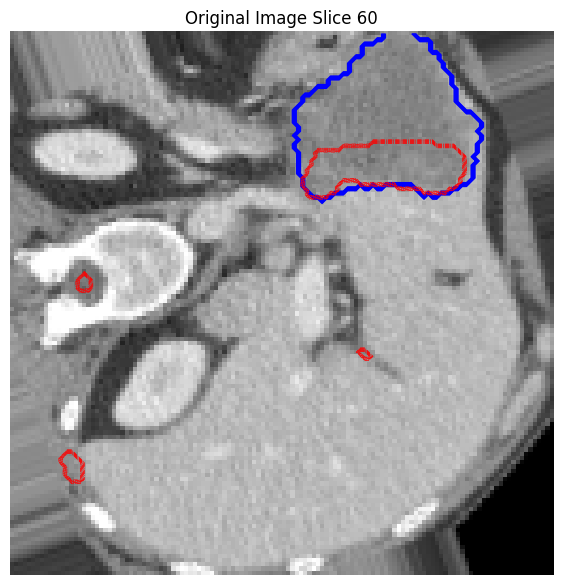

skipping
skipping
skipping
skipping


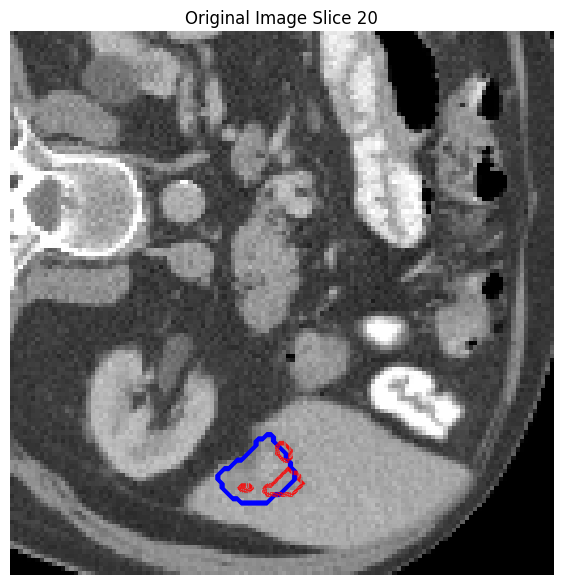

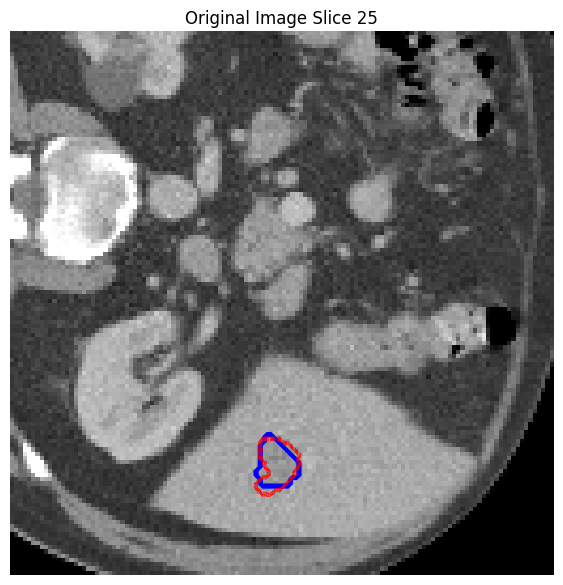

skipping
skipping


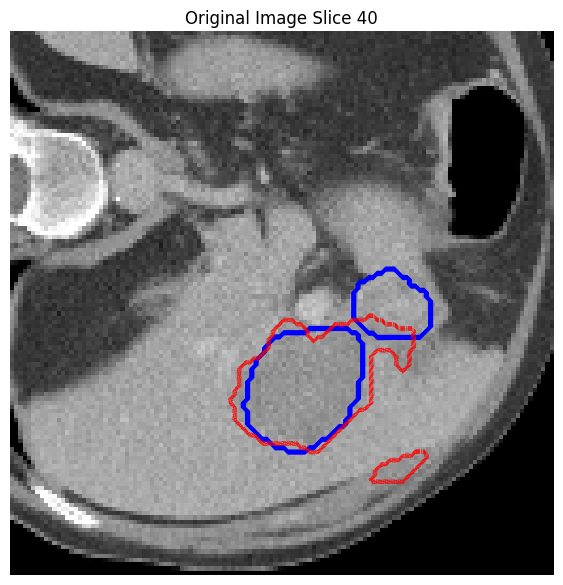

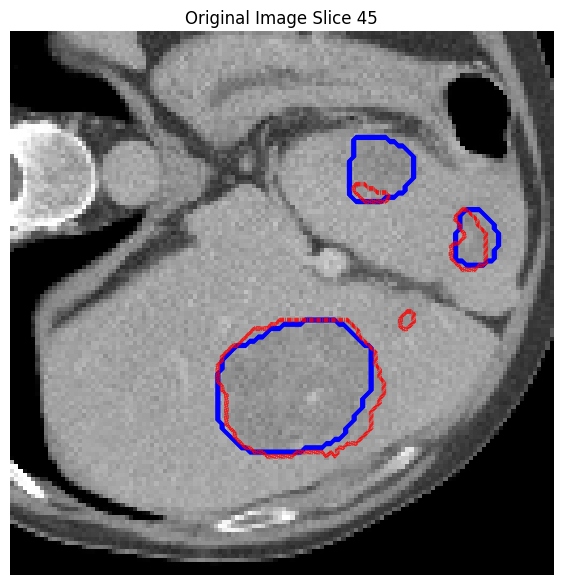

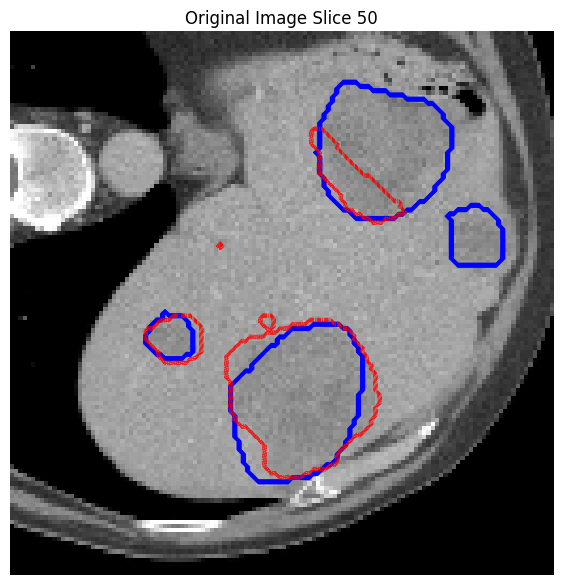

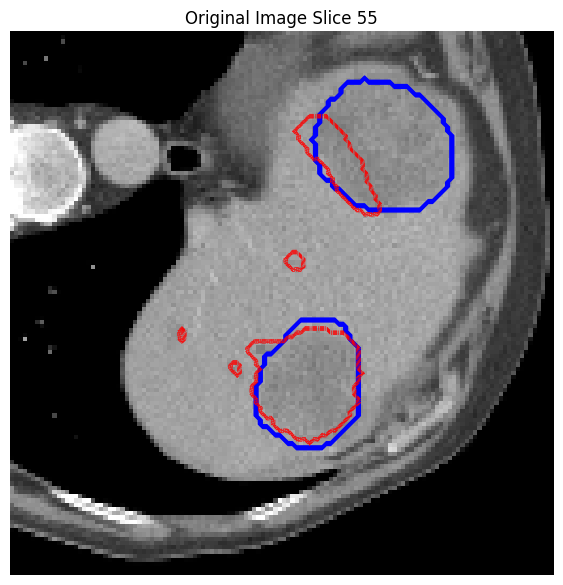

skipping


In [18]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import os
import random
import cv2

import cv2 as cv
import random
def visulaize_slice(input, label, prediction, saveDir,upper_limit=0.5):
    # where 24 is width and 24 is height
    # the depth is 64 ie last dimension
    # we will plot every 5th slice of the volume
    # so we will have 64/5 = 12 slices
    # we will show a row of 6 images
    count = 0
    for i in range(0, label.shape[-1], 5):
        mask = np.zeros(
            (input.shape[2], input.shape[3]))  # (width,height)
#         print(mask.shape)
        mask[label[0, 0, :, :, i] == 1] = 1

        predicted_mask = np.zeros(
            (prediction.shape[2], prediction.shape[3]))  # (width,height)

        predicted_mask[prediction[0, 0, :, :, i] > upper_limit] = 1
        # only plot pic if it have mask detected
        if np.sum(predicted_mask) == 0 or np.sum(mask) == 0:
            print("skipping")
            continue
        # print(np.sum(predicted_mask))
        plt.figure(figsize=(24, 24))
        plt.subplot(3, 3, count + 1)
        count = (count+1)%6
        plt.imshow(input[0, 0, :, :, i], cmap='gray')
        plt.contour(mask, colors='blue', linewidths=1)  # liver mask
        # we will plot the predicted mask contour with dashed lines with seperatio between the dashes as 2
        plt.contour(predicted_mask, colors='red',
                    linewidths=0.5, linestyles="dashdot")  # predicted liver mask

        plt.title(f'Original Image Slice {i}')
        plt.axis('off')
        plt.show()
        # check if the directory exists
        if not os.path.exists(f'{saveDir}/images'):
            os.makedirs(f'{saveDir}/images')
        # gnerate the image name with random number
        # hash = random.getrandbits(128)
        plt.savefig(f'{saveDir}/images/{upper_limit}_{hash}_{i}.png')
        plt.close()
        # try:
        #     # making another directory name image2
        #     if not os.path.exists(f'{saveDir}/images2'):
        #         os.makedirs(f'{saveDir}/images2')
        #     # save the original image
        #     cv.imwrite(f'{saveDir}/images2/{upper_limit}_{hash}_{i}.png', input[0, 0, :, :, i])
        # except:
        #     continue
        


# Usage
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
model.eval()

with torch.no_grad():
    for i, (vol, mask) in enumerate(test_loader):
        vol = vol.to(device)
        mask = mask.to(device)
        res = model(vol)
        
        # Move tensors back to CPU for visualization
        vol_cpu = vol.cpu()
        mask_cpu = mask.cpu()
        res_cpu = res.cpu()
        
        visulaize_slice(vol_cpu, mask_cpu, res_cpu, "out")
        
        # Optional: limit the number of samples to visualize
        if i >= 5:  # Visualize only the first 5 samples
            break